In [17]:
import os
import openai
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
import sys , os
sys.path.insert(0, "../")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from openai import OpenAI
from data_ingestion import prepare_hybird_search
from search_process import do_search

In [ ]:
# ----------------------------
# CONFIG
# ----------------------------
EVAL_MODEL = "gpt-4o-mini"         # model you're evaluating
JUDGE_MODEL = "gpt-4-turbo"        # stronger model for grading
EMBED_MODEL = "text-embedding-3-large"

In [20]:
ground_truth = pd.read_csv("../data/ground-truth-data.csv").to_dict(orient="records")
prepare_dict = prepare_hybird_search("../data/data.csv")

In [21]:
# ----------------------------
# Helper: get embedding vector
# ----------------------------
def embed_text(text: str) -> np.ndarray:
    if not text.strip():
        return np.zeros((1, 1536))
    resp = openai.embeddings.create(model=EMBED_MODEL, input=text)
    return np.array(resp.data[0].embedding).reshape(1, -1)

In [22]:
# ----------------------------
# Helper: LLM-as-a-Judge scoring
# ----------------------------
def judge_answer(question: str, model_answer: str, reference_answer: str) -> dict:
    client = OpenAI()

    grading_prompt = f"""
You are an expert evaluator. You will receive:
1. A question
2. The model's answer
3. The correct reference answer

Score the model answer on the following criteria from 1 to 5 (5 = excellent, 1 = poor):
- **Accuracy**: Does the answer correctly address the question?
- **Faithfulness**: Does the answer stay grounded in the reference?
- **Completeness**: Does it fully answer the question?

Return the result strictly as JSON with keys accuracy, faithfulness, completeness.
Question: {question}
Model answer: {model_answer}
Reference answer: {reference_answer}
"""

    resp = client.chat.completions.create(
        model=JUDGE_MODEL,
        messages=[{"role": "system", "content": grading_prompt}],
        temperature=0
    )

    # try to parse the JSON
    try:
        import json
        content = resp.choices[0].message.content
        scores = json.loads(content)
    except:
        scores = {"accuracy": None, "faithfulness": None, "completeness": None}
    return scores

### gpt-4o-mini ###

In [24]:
model = "gpt-4o-mini"
gpt_4o_mini_answers = []
o4_index = []

In [27]:
for i, rec in enumerate(tqdm(ground_truth)):
    if i in o4_index:
        continue
    q = rec["question"]
    ref = rec["expected_answer"]

    # 1️⃣ Get model answer (RAG pipeline)
    rag_result = do_search(q, prepare_dict, model=EVAL_MODEL)
    model_answer = rag_result["answer"]

    # 2️⃣ Compute embedding similarity
    emb_model = embed_text(model_answer)
    emb_ref = embed_text(ref)
    cosine_sim = float(cosine_similarity(emb_model, emb_ref)[0][0])

    # 3️⃣ LLM-as-a-Judge grading
    judge_scores = judge_answer(q, model_answer, ref)

    # 4️⃣ Store result
    gpt_4o_mini_answers.append({
        "id": rec.get("id"),
        "question": q,
        "reference_answer": ref,
        "model_answer": model_answer,
        "cosine_similarity": cosine_sim,
        **judge_scores
    })
    o4_index.append(i)

100%|██████████| 445/445 [1:30:42<00:00, 12.23s/it] 


In [28]:
df_results = pd.DataFrame(gpt_4o_mini_answers)
df_results.to_csv("../data/gpt_4o_mini_eval_results.csv", index=False)

### gpt-3.5-turbo ###

In [32]:
EVAL_MODEL = "gpt-3.5-turbo"         # model you're evaluating
gpt_3_5_turbo_answers = []
gpt_3_5_index = []

In [33]:
for i, rec in enumerate(tqdm(ground_truth)):
    if i in gpt_3_5_index:
        continue
    q = rec["question"]
    ref = rec["expected_answer"]

    # 1️⃣ Get model answer (RAG pipeline)
    rag_result = do_search(q, prepare_dict, model=EVAL_MODEL)
    model_answer = rag_result["answer"]

    # 2️⃣ Compute embedding similarity
    emb_model = embed_text(model_answer)
    emb_ref = embed_text(ref)
    cosine_sim = float(cosine_similarity(emb_model, emb_ref)[0][0])

    # 3️⃣ LLM-as-a-Judge grading
    judge_scores = judge_answer(q, model_answer, ref)

    # 4️⃣ Store result
    gpt_3_5_turbo_answers.append({
        "id": rec.get("id"),
        "question": q,
        "reference_answer": ref,
        "model_answer": model_answer,
        "cosine_similarity": cosine_sim,
        **judge_scores
    })
    gpt_3_5_index.append(i)

100%|██████████| 445/445 [1:06:41<00:00,  8.99s/it]


In [34]:
df_gpt_3_5_results = pd.DataFrame(gpt_3_5_turbo_answers)
df_gpt_3_5_results.to_csv("../data/gpt3_5_turbo_eval_results.csv", index=False)

In [35]:
def load_and_merge_results(path_a: str, path_b: str, model_a: str, model_b: str):
    df_a = pd.read_csv(path_a).rename(columns={
        "cosine_similarity": f"cosine_{model_a}",
        "accuracy": f"accuracy_{model_a}"
    })
    df_b = pd.read_csv(path_b).rename(columns={
        "cosine_similarity": f"cosine_{model_b}",
        "accuracy": f"accuracy_{model_b}"
    })

    merged = pd.merge(df_a, df_b, on="id", suffixes=(f"_{model_a}", f"_{model_b}"))
    return merged


In [36]:
import matplotlib.pyplot as plt
import numpy as np

def plot_model_comparison_bar(merged: pd.DataFrame, model_a: str, model_b: str):
    metrics = ["cosine", "accuracy"]
    avg_a = [
        merged[f"cosine_{model_a}"].mean(),
        merged[f"accuracy_{model_a}"].mean()
    ]
    avg_b = [
        merged[f"cosine_{model_b}"].mean(),
        merged[f"accuracy_{model_b}"].mean()
    ]

    x = np.arange(len(metrics))
    width = 0.35

    plt.figure(figsize=(8, 5))
    plt.bar(x - width/2, avg_a, width, label=model_a, color="#007ACC")
    plt.bar(x + width/2, avg_b, width, label=model_b, color="#FFB000")

    for i, v in enumerate(avg_a):
        plt.text(i - width/2, v + 0.01, f"{v:.2f}", ha="center", fontsize=9)
    for i, v in enumerate(avg_b):
        plt.text(i + width/2, v + 0.01, f"{v:.2f}", ha="center", fontsize=9)

    plt.xticks(x, ["Cosine Similarity", "Accuracy (1-5)"])
    plt.ylim(0, 1.05 if metrics[0] == "cosine" else 5.2)
    plt.title("📊 Overall LLM Performance Comparison")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


In [38]:
merged = load_and_merge_results(
    "../data/gpt_4o_mini_eval_results.csv",
    "../data/gpt3_5_turbo_eval_results.csv",
    "gpt4o",
    "gpt35"
)

C:\Users\zaina\AppData\Local\Temp\ipykernel_15912\1544078318.py:33: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\zaina\AppData\Local\Temp\ipykernel_15912\1544078318.py:33: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
C:\Users\zaina\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


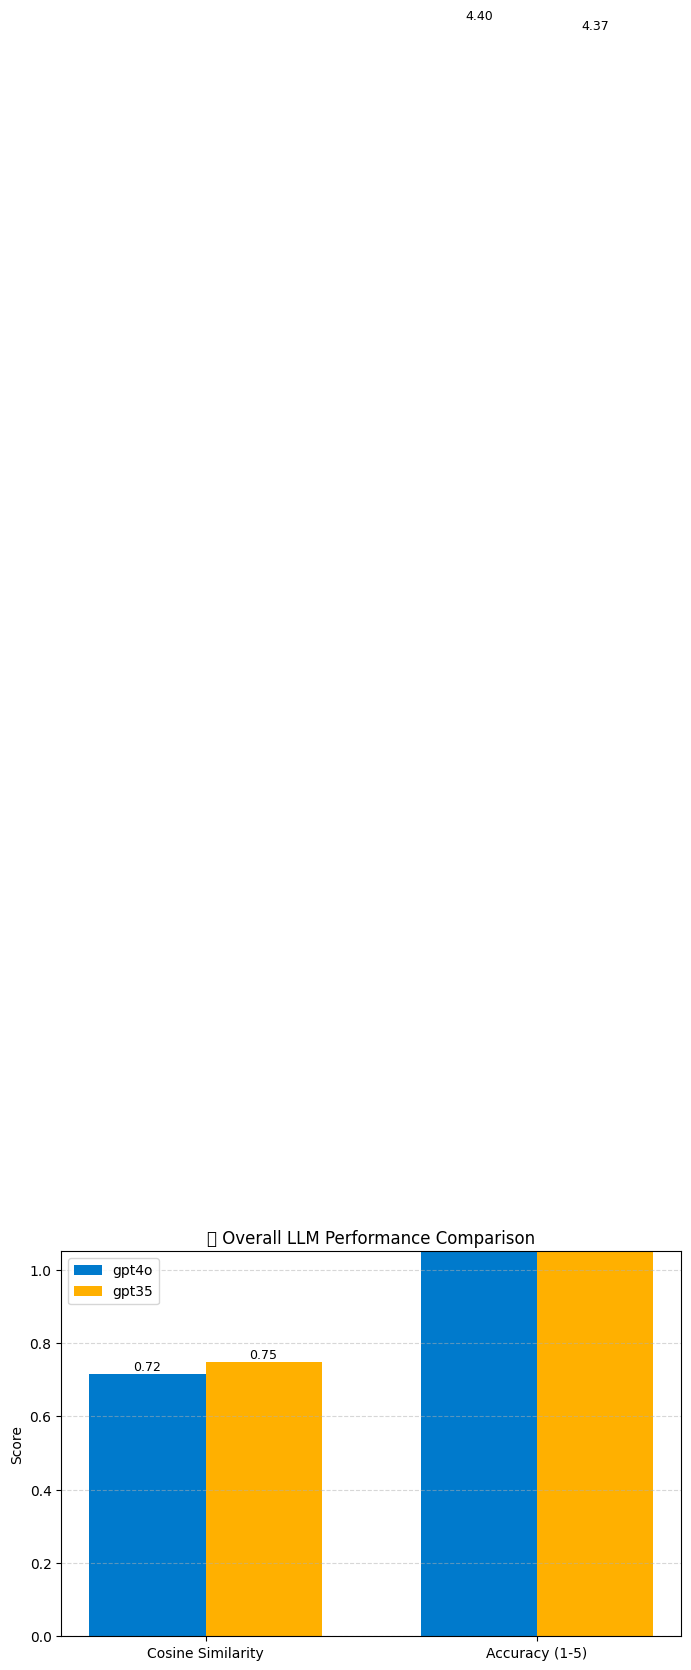

In [39]:
plot_model_comparison_bar(merged, "gpt4o", "gpt35")

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\zaina\AppData\Local\Temp\ipykernel_15912\2502711122.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_results['cosine_similarity'], label='4o-mini')
C:\Users\zaina\AppData\Local\Temp\ipykernel_15912\2502711122.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt_3_5_results['

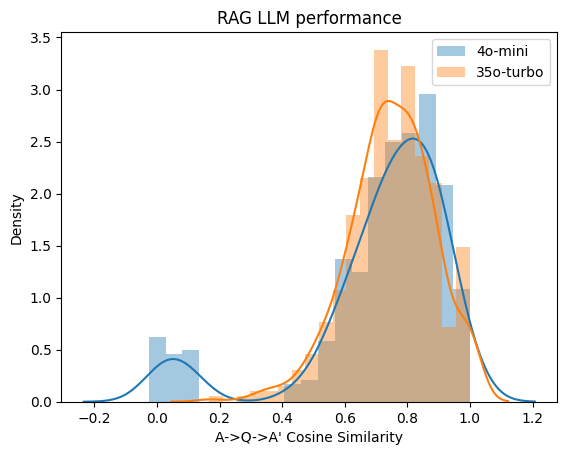

In [43]:
sns.distplot(df_results['cosine_similarity'], label='4o-mini')
sns.distplot(df_gpt_3_5_results['cosine_similarity'], label='35o-turbo')

plt.title("RAG LLM performance")
plt.xlabel("A->Q->A' Cosine Similarity")
plt.legend()